In [1]:
import numpy as np
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
## Import dataset
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
seed = 40
np.random.seed(seed)
tf.set_random_seed(seed)

In [4]:
mnist_data = input_data.read_data_sets('./data/', one_hot=True)
train_imgs = mnist_data.train.images
test_imgs = mnist_data.test.images

train_labels = mnist_data.train.labels
test_labels = mnist_data.test.labels

print("")
print('Train images : ', train_imgs.shape, ' , train labels :', train_labels.shape)
print('Test images : ', test_imgs.shape, ' , test labels :', test_labels.shape)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz

('Train images : ', (55000, 784), ' , train labels :', (55000, 10))
('Test images : ', (10000, 784), ' , test labels :', (10000, 10))


In [5]:
# define a linear FC learning layer

def linear(input_node, num_out, scope):
    with tf.variable_scope(scope or 'linear') as scope:
        w = tf.get_variable('w', [input_node.get_shape()[1], num_out], initializer=tf.truncated_normal_initializer())
        b = tf.get_variable('b', [num_out], initializer=tf.constant_initializer())
        return tf.matmul(input_node, w) + b

In [6]:
client_id = 0
learning_rate = 0.001


In [7]:
class FedLearnClient(object):
    def __init__(self, train_imgs, train_labels, client_id, learning_rate=0.0001, batch_size=64):
        self.train_imgs = train_imgs
        self.train_labels = train_labels
        self.client_id = client_id
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.loss_hist = []
        self.name = format('client_%d' %self.client_id)
        self._create_model(128)
    
    def _create_model(self, num_hidden):
        with tf.variable_scope(self.name):
            self.x = tf.placeholder(tf.float32, [None, 784], name="x")
            self.y = tf.placeholder(tf.float32, [None, 10], name="y")
            h1 = tf.nn.tanh(linear(self.x, num_hidden, 'h1'))
            self.y_logits = linear(h1, 10, 'h2')
            
            
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.y_logits, labels = self.y))
            self.train_step  = tf.train.GradientDescentOptimizer(self.learning_rate).minimize(self.loss)
    
    def train(self, session, num_steps):
        for i in range(num_steps):
            for j in range(self.train_imgs.shape[0]//self.batch_size):
                batch_xs = self.train_imgs[j* self.batch_size: (j+1)*self.batch_size]
                batch_ys = self.train_labels[j* self.batch_size: (j+1) * self.batch_size]
                _, cur_loss = session.run([self.train_step, self.loss], feed_dict={self.x : batch_xs, self.y: batch_ys})
            self.loss_hist.append(cur_loss)
            
    def get_loss_hist(self):
        return self.loss_hist
                
    def get_weights(self, session):
        return session.run([v for v in tf.trainable_variables() if v.name.startswith(self.name)])
    
    def set_weights(self, session, weights):
        my_weights = [v for v in tf.trainable_variables() if v.name.startswith(self.name)]
        for i, v in enumerate(my_weights):
            session.run(v.assign(weights[i]))
            
    def get_name(self):
        return self.name
    
        
        
            
            

In [8]:
# simulator = FedLearningSimulator(5, train_imgs, train_labels, test_imgs, test_labels, learning_rate, 64)
# for i in range(10):
#     simulator.train(1)
#     #simulator.merge_weights()
# simulator.plot_loss_hist()

class FedLearningSimulator(object):
    def __init__(self, num_clients, train_imgs, train_labels, test_imgs, test_labels, learning_rate, batch_size):
        self.num_clients = num_clients
        self.train_imgs = train_imgs
        self.train_labels = train_labels
        self.test_imgs = test_imgs
        self.test_labels = test_labels
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.clients = []
        self.session = tf.Session()
        self.clients_data = self._distribute_data(self.num_clients)
        for i in range(num_clients):
            self.clients.append(self._create_client(i, self.clients_data[i][0], self.clients_data[i][1]))
#         self.session.run(tf.initialize_all_variables())
#         tf.global_variables_initializer
        self.session.run(tf.global_variables_initializer())
    
    def _distribute_data(self, num_clients):
        clients_data = []
        client_share = self.train_imgs.shape[0] // num_clients
        for i in range(num_clients):
            client_imgs = self.train_imgs[i*client_share: (i+1)*client_share]
            client_labels = self.train_labels[i*client_share: (i+1)*client_share]
            
            clients_data.append((client_imgs, client_labels))
        return clients_data
    
    def _create_client(self, i, client_x, client_y):
        return FedLearnClient(client_x, client_y, i, self.learning_rate)
    
    def train(self, num_steps):
        for i, client in enumerate(self.clients):
            client.train(self.session, num_steps)
            
    def merge_weights(self):
        clients_weights = [x.get_weights(self.session) for x in self.clients]
        final_weights = self.get_final_weight(clients_weights)
        
        ## Set the final weights
        for c in self.clients:
            c.set_weights(self.session, final_weights)
    
    def get_final_weight(self, clients_weights):
        """ client_weights is a list of weights for every client
        length of list = number of clients
        each client has a list of length = number of individual parameters
        """
        ## Merge weights by average
        final_weights = np.mean(np.array(clients_weights), axis=0)
        return final_weights
    
    def plot_loss_hist(self):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        for i in range(self.num_clients):
            client_loss = self.clients[i].get_loss_hist()
            plt.plot(client_loss, label=self.clients[i].get_name())
        ax.legend()
        plt.xlabel('Iteration')
        plt.ylabel('Training loss')
        fig.show()
        
    def get_clients_loss_hist(self):
        return [x.get_loss_hist() for x in self.clients]
            
            

In [9]:
simulator = FedLearningSimulator(5, train_imgs, train_labels, test_imgs, test_labels, learning_rate, 64)

/home/tianwei/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


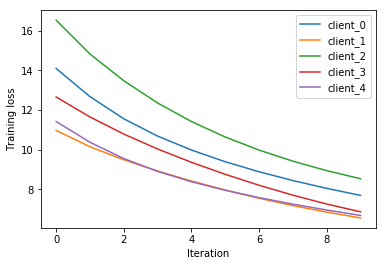

In [10]:
for i in range(10):
    simulator.train(1)
    #simulator.merge_weights()
simulator.plot_loss_hist()

In [11]:
[x[-1] for x in simulator.get_clients_loss_hist()]

[7.6879749, 6.5524416, 8.5282822, 6.8607025, 6.677969]